# Atividade Integradora

# Road Map
* bz: (Marcelo)
       - explodir atributos e horas de funcionamento
       - tratar atributos - selecionar os que fazem sentido e transforar true ou false para dummy
                        * Atributos (Marcelo)  - até good for kids
                        * Atributos (Viviane) - good for meal em diante
       - rodar um [k-means](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=kmeans#pyspark.ml.clustering.KMeans) na base
       - criar uma lista de business_id e no do cluster (cluster_bz)
       (- join horários mais frequentados pela base de check-in) - Viviane


* usr (Rafa)
       - hclust de usuários para traçar perfil comum (perfil_usr)
       - identificar usuários mais engajados/populares/com reviews mais bem avaliadas (cluster_usr)
       - entender 'elite'

       
* rv:
        - Join a lista de cluster_bz na base pelo business_id
        - Join lista de cluster de usuários (perfil_usr)
        - Juntar atributos das tips na base: contagem, compliments, se teve ou não tips.
        - Text mining nas reviews/tip para encontrar as palavras com maior frequência em cada cluster_bz  e cluster_usr
        - Lista com palavras mais frequentes e nota média por cluster_bz
        (- Comparar horário dos reveiws com quantidade de check-ins no estabelecimento)
        - avaliar evolução das notas por cluster_bz e por perfil de usuário (cluster_usr)
        - filtrar apenas usuários que fazem mais reviews?
        
* base final:

* modelo:
    - input dos dados do perfil usuário + reviews realizadas + restaurantes frequentados
    - output: número do cluster de restaurantes filtrado com os não frequentados



## Criando Ambiente Spark

In [1]:
import findspark as fs
from pyspark.sql import SparkSession

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as f
from pyspark.sql.window import Window
from pyspark.ml.feature import StopWordsRemover
import pandas as pd
import seaborn as sns
sns.set(style="ticks", palette="pastel")
import os
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#MAC Local (Viviane)
spark_location='/Users/vivi/server/spark' # Set your own
java8_location= '/Library/Java/JavaVirtualMachines/jdk1.8.0_251.jdk/Contents/Home/' # Set your own
os.environ['JAVA_HOME'] = java8_location
fs.init(spark_home=spark_location)

In [4]:
#datapath = 'C:\\Users\\RuWindows\\Desktop\\PI\\yelp_dataset\\' #Marcelo
#datapath = '../data/yelp' #servidor AWS
datapath = 'data' #Viviane

In [5]:
files = sorted(os.listdir(datapath))
files

['.DS_Store',
 'dataset list.rtf',
 'yelp_academic_dataset_business.json',
 'yelp_academic_dataset_checkin.json',
 'yelp_academic_dataset_review.json',
 'yelp_academic_dataset_tip.json',
 'yelp_academic_dataset_user.json']

In [6]:
!head data/yelp_academic_dataset_checkin.json

{"business_id":"--1UhMGODdWsrMastO9DZw","date":"2016-04-26 19:49:16, 2016-08-30 18:36:57, 2016-10-15 02:45:18, 2016-11-18 01:54:50, 2017-04-20 18:39:06, 2017-05-03 17:58:02, 2019-03-19 22:04:48"}
{"business_id":"--6MefnULPED_I942VcFNA","date":"2011-06-04 18:22:23, 2011-07-23 23:51:33, 2012-04-15 01:07:50, 2012-05-06 23:08:42, 2012-06-08 22:43:12, 2012-08-06 23:20:52, 2012-08-19 18:30:44, 2013-01-27 23:49:51, 2013-03-01 01:22:29, 2013-03-23 21:53:47, 2013-03-24 01:11:51, 2013-05-20 00:12:25, 2013-06-29 22:50:57, 2013-07-01 15:58:04, 2013-07-01 22:35:42, 2013-07-28 21:46:49, 2013-08-02 22:06:03, 2013-08-11 18:42:03, 2013-08-23 01:29:56, 2013-09-17 17:40:36, 2013-09-20 23:36:30, 2013-09-24 23:50:18, 2013-10-12 23:11:13, 2013-11-24 18:40:15, 2013-12-12 02:52:54, 2013-12-26 17:33:17, 2013-12-30 00:27:37, 2014-03-28 23:38:23, 2014-04-25 22:48:11, 2014-04-28 22:56:07, 2014-05-03 01:02:47, 2014-05-19 17:08:37, 2014-06-16 00:04:51, 2014-06-22 17:21:27, 2014-07-04 19:13:34, 2014-07-11 15:46:29, 

In [7]:
# Spark Session
spark = SparkSession.builder \
    .master('local[*]') \
    .appName('Integradora Yelp') \
    .config("spark.ui.port", "4060") \
    .getOrCreate()

spark = SparkSession.builder \
            .master('local[8]') \
            .appName('Yelp Integradora') \
            .getOrCreate()

In [8]:
sc = spark.sparkContext

In [9]:
spark#.stop()

## Importando as Bases Origem - Raw

In [10]:
#usr_raw = spark.read.json(datapath+'/yelp_academic_dataset_user.json')
#rv_raw = spark.read.json(datapath+'/yelp_academic_dataset_review.json')
bz_raw = spark.read.json(datapath+'/yelp_academic_dataset_business.json')
#tp_raw = spark.read.json(datapath+'/yelp_academic_dataset_tip.json')
#bz_raw = spark.read.json(datapath+'/yelp_academic_dataset_business.json')
ch_raw = spark.read.json(datapath+'/yelp_academic_dataset_checkin.json')

In [10]:
ch_raw = spark.read.json(datapath+'/yelp_academic_dataset_checkin.json')

In [26]:
bz_raw.createOrReplaceTempView('bz')
#rv_raw.createOrReplaceTempView('rv')
#usr_raw.createOrReplaceTempView('usr')
#tp_raw.createOrReplaceTempView('tp')

In [11]:
# Visualizando Estrutura
ch_raw.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- date: string (nullable = true)



In [12]:
# Verificando o SQL
print(spark.catalog.listTables())

[]


In [20]:
# bz_raw.columns

In [21]:
# usr_raw.columns

In [22]:
# rv_raw.columns

In [23]:
# tp_raw.columns

In [13]:
ch_raw.columns

['business_id', 'date']

# Base Check-ins

Encontrar:

    - Horário mais movimentado
    - dia da semana mais movimentado
    - Perfil de check-ins por dia da semana

In [13]:
ch = ch_raw.withColumn('dt', f.explode(f.split(f.col('date'),', ')))

In [14]:
ch.createOrReplaceTempView('ch')

In [56]:
ch1 = spark.sql('''
            SELECT business_id, dt,
            DATE(dt) AS date,
            DAYOFWEEK(dt) AS dow,
            MONTH(dt) AS month,
            YEAR(dt) AS year,
            HOUR(dt) AS hour,
            DAY(dt) AS day
            
            FROM ch
            
            ''')

In [57]:
ch1.createOrReplaceTempView('ch1')

In [59]:
ch2 = spark.sql('''
            SELECT  business_id, year, month, dow, day,
                    COUNT(date) AS count
            
            FROM ch1
            
            GROUP BY business_id, year, month, dow, day
            ORDER BY count DESC
                 
            ''')

In [60]:
ch2.createOrReplaceTempView('ch2')

In [61]:
ch2.show()

+--------------------+----+-----+---+---+-----+
|         business_id|year|month|dow|day|count|
+--------------------+----+-----+---+---+-----+
|RESDUcs7fIiihp38-...|2019|   10|  1|  6|  288|
|K2PHx0JgNuZh7b89g...|2017|    7|  7| 15|  264|
|RESDUcs7fIiihp38-...|2019|    9|  1|  1|  263|
|RESDUcs7fIiihp38-...|2019|   10|  7|  5|  261|
|RESDUcs7fIiihp38-...|2019|    8|  7| 31|  246|
|RESDUcs7fIiihp38-...|2019|    9|  2|  2|  240|
|RESDUcs7fIiihp38-...|2019|   11|  1| 10|  230|
|RESDUcs7fIiihp38-...|2019|    9|  1| 22|  228|
|RESDUcs7fIiihp38-...|2019|   11|  7| 16|  227|
|RESDUcs7fIiihp38-...|2019|   11|  7|  2|  226|
|RESDUcs7fIiihp38-...|2019|   10|  7| 12|  224|
|RESDUcs7fIiihp38-...|2019|   11|  1|  3|  219|
|RESDUcs7fIiihp38-...|2019|    9|  7| 21|  218|
|RESDUcs7fIiihp38-...|2019|   10|  7| 19|  212|
|_GdzDB3SU9Ni7mAOQ...|2019|   11|  4| 20|  210|
|RESDUcs7fIiihp38-...|2019|   11|  7|  9|  209|
|RESDUcs7fIiihp38-...|2019|   10|  7| 26|  208|
|RESDUcs7fIiihp38-...|2019|   11|  1| 24

In [4]:
ch3 = spark.sql('''
            SELECT  business_id,
                    avg(count) AS avg_frequency
            
            FROM ch2
            
            GROUP BY business_id
            ORDER BY avg_frequency DESC
            
            ''').show()

NameError: name 'spark' is not defined

In [19]:
df = spark.sql('''
            SELECT *
            FROM ch2

            WHERE business_id = 'BxCzy1WOVxOrr_G7V4BIvg'
            
            ''').toPandas()

In [20]:
df.head()

,business_id,year,month,dow,hour,count
0,BxCzy1WOVxOrr_G7V4BIvg,2015,5,7,17,4
1,BxCzy1WOVxOrr_G7V4BIvg,2016,11,7,19,3
2,BxCzy1WOVxOrr_G7V4BIvg,2016,9,7,14,3
3,BxCzy1WOVxOrr_G7V4BIvg,2012,7,7,16,3
4,BxCzy1WOVxOrr_G7V4BIvg,2011,5,1,16,3


In [40]:
df2 = df.groupby(['month','dow'])['count'].sum().unstack('dow').fillna(0)                           

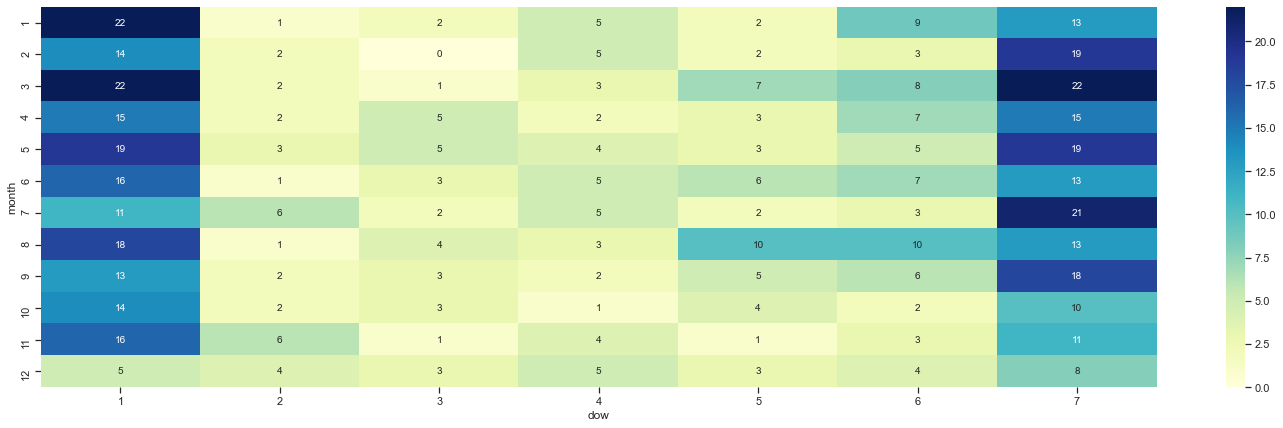

In [41]:
plt.figure(figsize = (25,7))
sns.heatmap(data = df2, cmap="YlGnBu", annot = True)

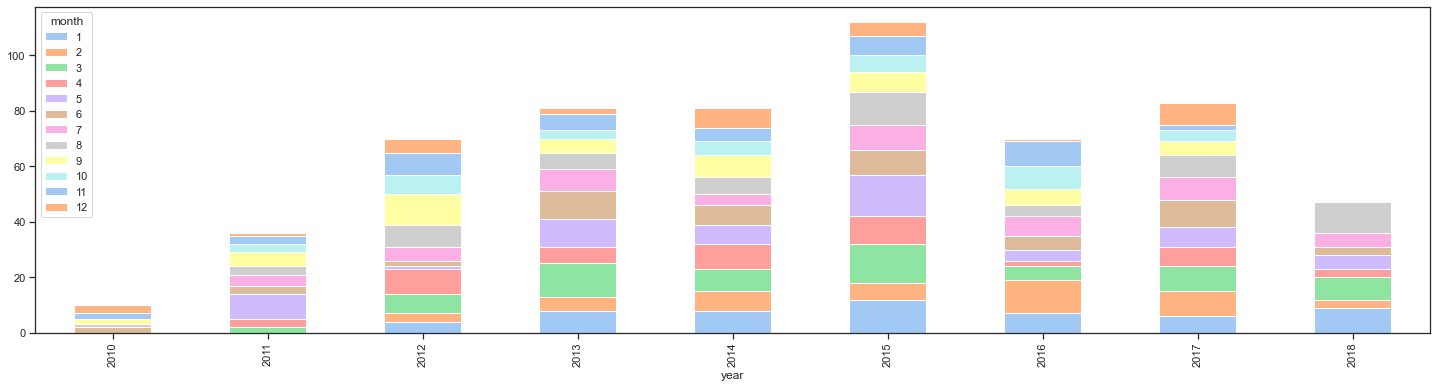

In [24]:
df.groupby(['year','month'])['count'].agg('sum').unstack('month').plot(kind = 'bar', stacked = True, figsize = (25,6))

# Base Business

In [63]:
# Abertura dos atributos para colunas
dfs = []

for x in ["hours", "attributes"]:
    cols = bz_raw.select(f"{x}.*").columns
    for col in cols:
        try:
            dfs.append(dfs[-1].withColumn(col, f.col(f"{x}.{col}")))
        except IndexError:
            dfs.append(bz_raw.withColumn(col, f.col(f"{x}.{col}")))
            
df_final = dfs[-1].drop("hours", "attributes")
    
df_final.createOrReplaceTempView("bz")
df_final.printSchema()

root
 |-- address: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- city: string (nullable = true)
 |-- is_open: long (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- name: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- stars: double (nullable = true)
 |-- state: string (nullable = true)
 |-- Friday: string (nullable = true)
 |-- Monday: string (nullable = true)
 |-- Saturday: string (nullable = true)
 |-- Sunday: string (nullable = true)
 |-- Thursday: string (nullable = true)
 |-- Tuesday: string (nullable = true)
 |-- Wednesday: string (nullable = true)
 |-- AcceptsInsurance: string (nullable = true)
 |-- AgesAllowed: string (nullable = true)
 |-- Alcohol: string (nullable = true)
 |-- Ambience: string (nullable = true)
 |-- BYOB: string (nullable = true)
 |-- BYOBCorkage: string (nullable = true)

In [130]:
cols = bz_raw.select('attributes.*').columns

In [132]:
cols

['AcceptsInsurance',
 'AgesAllowed',
 'Alcohol',
 'Ambience',
 'BYOB',
 'BYOBCorkage',
 'BestNights',
 'BikeParking',
 'BusinessAcceptsBitcoin',
 'BusinessAcceptsCreditCards',
 'BusinessParking',
 'ByAppointmentOnly',
 'Caters',
 'CoatCheck',
 'Corkage',
 'DietaryRestrictions',
 'DogsAllowed',
 'DriveThru',
 'GoodForDancing',
 'GoodForKids',
 'GoodForMeal',
 'HairSpecializesIn',
 'HappyHour',
 'HasTV',
 'Music',
 'NoiseLevel',
 'Open24Hours',
 'OutdoorSeating',
 'RestaurantsAttire',
 'RestaurantsCounterService',
 'RestaurantsDelivery',
 'RestaurantsGoodForGroups',
 'RestaurantsPriceRange2',
 'RestaurantsReservations',
 'RestaurantsTableService',
 'RestaurantsTakeOut',
 'Smoking',
 'WheelchairAccessible',
 'WiFi']

In [114]:
df_final.select(cols[-10:]).distinct().show()

+-------------------------+-------------------+------------------------+----------------------+-----------------------+-----------------------+------------------+----------+--------------------+-------+
|RestaurantsCounterService|RestaurantsDelivery|RestaurantsGoodForGroups|RestaurantsPriceRange2|RestaurantsReservations|RestaurantsTableService|RestaurantsTakeOut|   Smoking|WheelchairAccessible|   WiFi|
+-------------------------+-------------------+------------------------+----------------------+-----------------------+-----------------------+------------------+----------+--------------------+-------+
|                     null|              False|                    True|                     1|                  False|                   True|              True|u'outdoor'|                null| 'free'|
|                     null|               None|                    null|                  null|                  False|                  False|              None|      null|               

- Valores únicos em cada coluna de atributos. As que não são True or False ou valores numéricos, iremos desconsiderar da base.

In [133]:
[df_final.groupBy(cols[x]).count().show() for x in range(len(cols))]

+----------------+------+
|AcceptsInsurance| count|
+----------------+------+
|            None|    14|
|           False|  2386|
|            null|200733|
|            True|  6260|
+----------------+------+

+-----------+------+
|AgesAllowed| count|
+-----------+------+
|       None|     3|
|       null|209257|
|  u'18plus'|    15|
|  u'21plus'|    82|
| u'allages'|    20|
|  u'19plus'|    16|
+-----------+------+

+----------------+------+
|         Alcohol| count|
+----------------+------+
|            None|    90|
|         u'none'| 16723|
|            null|158555|
| 'beer_and_wine'|  1867|
|          'none'|  5951|
|u'beer_and_wine'|  5117|
|     u'full_bar'| 17462|
|      'full_bar'|  3628|
+----------------+------+

+--------------------+-----+
|            Ambience|count|
+--------------------+-----+
|{'romantic': Fals...|   28|
|{'touristy': None...|    2|
|{'touristy': Fals...|    2|
|{'touristy': Fals...|    4|
|{'touristy': None...|    1|
|{'touristy': None...|    1|
|{'tou

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

# Criando Base Única Principal

## Unificando as Bases para contrução dos Modelos - "Joins"

Juntando as informações de reviews, estabelecimentos da cidade escolhidas e usuários que frequentam esses estabelecimentos.

### Reviews + Business

In [25]:
base = spark.sql("""
       SELECT A.business_id,
        A.cool AS cool_rv,
        A.date AS date_rv,
        A.funny AS funny_rv,
        A.review_id,
        A.stars AS stars_rv,
        A.text AS text_rv,
        A.useful AS useful_rv,
        A.user_id,        
        
        B.address AS address_bz,
        B.categories AS categories_bz,
        B.city AS city_bz,
        B.hours AS hours_bz,
        B.is_open AS is_open_bz,
        B.latitude AS latitude_bz,
        B.longitude AS longitude_bz,
        B.name AS name_bz,
        B.postal_code AS postal_code_bz,
        B.review_count AS review_count_bz,
        B.stars AS stars_bz,
        B.state AS state_bz
 
        FROM rv as A 
        LEFT JOIN bz as B
        ON A.business_id = B.business_id
        
        WHERE B.city = 'Toronto'
        AND B.state = 'ON'
        AND B.review_count > 20
        AND (B.categories like '%Restaurant%' OR B.categories like '%Food%')
        """)

In [26]:
# base.show(5)

In [27]:
base.createOrReplaceTempView('base')

- Contagem da quantidade de linhas para garantir que a integridade do dataset ser mantém ao longo do processamento.

In [28]:
#linhas na base de reviews + business
# spark.sql('''
#             SELECT Count(*)
#             FROM base
#             ''').show()

### (Reviews + Business) + Users

In [29]:
base1 = spark.sql("""
        SELECT A.*,
        B.average_stars AS stars_usr,
        B.compliment_cool AS compliment_cool_usr,
        B.compliment_cute AS compliment_cute_usr,
        B.compliment_funny AS compliment_funny_usr,
        B.compliment_hot AS compliment_hot_usr,
        B.compliment_list AS compliment_list_usr,
        B.compliment_more AS compliment_more_usr,
        B.compliment_note AS compliment_note_usr,
        B.compliment_photos AS compliment_photos_usr,
        B.compliment_plain AS compliment_plain_usr,
        B.compliment_profile AS compliment_profile_usr,
        B.compliment_writer AS compliment_writer_usr,
        B.cool AS cool_usr,
        B.elite AS elite_usr,
        B.fans AS fans_usr,
        B.friends AS friends_usr,
        B.funny AS funny_usr,
        B.name AS name_usr,
        B.review_count AS review_count_usr,
        B.useful AS useful_usr,
        B.yelping_since AS yelping_since_usr

        FROM base as A LEFT JOIN usr as B
        
        ON A.user_id = B.user_id 
        
        """)

In [30]:
base1.createOrReplaceTempView('base1')

In [31]:
#linhas na base de reviews + business + users
# spark.sql('''
#             SELECT Count(*)
#             FROM base1
#             ''').show()

In [32]:
aux = spark.sql('''
            SELECT user_id, city_bz, yelping_since_usr,
            COUNT(review_id) AS city_review_counter_usr,
            review_count_usr
            
            FROM base1
            
            GROUP BY user_id, review_count_usr, city_bz, yelping_since_usr
            ORDER BY city_review_counter_usr DESC        
            
            ''')

In [33]:
aux.createOrReplaceTempView('aux')

In [34]:
# aux.show()

Aparentemente os usuários fazem reviews em estabelecimentos não só em Toronto. Para incluir essa informação no modelo, será criada uma variável com a relação entre as quantidade de reviews do usuário na cidade pela quantidade total de reviews do usuário.

- Média de reviews por usuário na cidade e total

In [35]:
# spark.sql('''
#             SELECT AVG(city_review_counter_usr), 
#              AVG(review_count_usr)
            
#             FROM aux       
            
#             ''').show()

- Remoção de usuários com apenas 1 review na cidade

In [36]:
base2 = spark.sql('''
            SELECT A.*,
            B.city_review_counter_usr,
            (B.city_review_counter_usr/B.review_count_usr) AS city_review_ratio_usr
            
            FROM base1 as A
            
            LEFT JOIN aux as B
            ON A.user_id = B.user_id
            
            WHERE B.city_review_counter_usr > 1
            
            ''')

In [37]:
base2.createOrReplaceTempView('base2')

In [38]:
#linhas na base de reviews + business + users
# spark.sql('''
#             SELECT Count(*)
#             FROM base2
#             ''').show()

- Classificação das avaliações em Boa (1 - maior do que 4) e Ruim ou inexistente (0 - menor do que 4).

In [39]:
base3 = spark.sql("""
        SELECT *,
        (CASE WHEN stars_rv >=4 THEN 1 ELSE 0 END) as class_rv,
        (CASE WHEN stars_bz >=4 THEN 1 ELSE 0 END) as class_bz,
        (CASE WHEN stars_usr >=4 THEN 1 ELSE 0 END) as class_usr
        
        FROM base2
        
        """)

In [40]:
base3.columns

['business_id',
 'cool_rv',
 'date_rv',
 'funny_rv',
 'review_id',
 'stars_rv',
 'text_rv',
 'useful_rv',
 'user_id',
 'address_bz',
 'categories_bz',
 'city_bz',
 'hours_bz',
 'is_open_bz',
 'latitude_bz',
 'longitude_bz',
 'name_bz',
 'postal_code_bz',
 'review_count_bz',
 'stars_bz',
 'state_bz',
 'stars_usr',
 'compliment_cool_usr',
 'compliment_cute_usr',
 'compliment_funny_usr',
 'compliment_hot_usr',
 'compliment_list_usr',
 'compliment_more_usr',
 'compliment_note_usr',
 'compliment_photos_usr',
 'compliment_plain_usr',
 'compliment_profile_usr',
 'compliment_writer_usr',
 'cool_usr',
 'elite_usr',
 'fans_usr',
 'friends_usr',
 'funny_usr',
 'name_usr',
 'review_count_usr',
 'useful_usr',
 'yelping_since_usr',
 'city_review_counter_usr',
 'city_review_ratio_usr',
 'class_rv',
 'class_bz',
 'class_usr']

In [41]:
base3.createOrReplaceTempView('base3')

In [42]:
# spark.sql('''
#             SELECT Count(*)
#             FROM base3
#             ''').show()

###   ((Reviews + Business) + Users ) + Tips

In [43]:
# spark.sql('''
#             SELECT business_id, user_id, 
#             count(text) AS tips_counter,
#             sum(compliment_count) as total_compliments
            
#             FROM tp
            
#             GROUP BY business_id, user_id
#             ORDER BY total_compliments DESC
#             ''').show()

In [44]:
base4 = spark.sql('''
            SELECT A.*,
            IFNULL(B.compliment_count,0) AS compliment_count_tip,
            IFNULL(B.text,'') AS tip
            
            FROM base3 as A
            
            LEFT JOIN tp as B
            ON (A.user_id = B.user_id AND A.business_id = B.business_id)
            
            ''')

In [45]:
# base4.select('business_id', 'user_id','tip','compliment_count_tip').show()

In [46]:
# base4.select('text_rv','tip').show()

## Tratamento do Texto

In [47]:
def word_clean(sdf,col,new_col):
    rv1 = sdf.withColumn(new_col,f.regexp_replace(f.col(col), "'d", " would"))
    rv2 = rv1.withColumn(new_col,f.regexp_replace(f.col(new_col), "'ve", " have"))
    rv3 = rv2.withColumn(new_col,f.regexp_replace(f.col(new_col), "'s", " is"))
    rv4 = rv3.withColumn(new_col,f.regexp_replace(f.col(new_col), "'re", " are"))
    rv5 = rv4.withColumn(new_col,f.regexp_replace(f.col(new_col), "n't", " not"))
    rv6 = rv5.withColumn(new_col,f.regexp_replace(f.col(new_col), '\W+', " "))
    rv7 = rv6.withColumn(new_col,f.lower(f.col(new_col)))
    return rv7

In [48]:
base5 = word_clean(base4,'text_rv','text_clean')
base6 = word_clean(base5,'tip','tip_clean')

In [49]:
# base6.select('text_clean','tip_clean').show()

- Contagem de amigos de cada usuário

In [50]:
base7 = base6.withColumn('friends_counter_usr', f.size(f.split(f.col('friends_usr'),',')))

In [51]:
base7.createOrReplaceTempView('base7')

In [52]:
base8 = spark.sql('''
            SELECT *,
            (CASE WHEN friends_usr = 'None' THEN 0 ELSE friends_counter_usr END) as friends_count_usr
            FROM base7
            ''')

In [53]:
df = base8.select('friends_usr','friends_counter_usr','friends_count_usr').limit(10).toPandas()

In [54]:
df.dtypes

friends_usr            object
friends_counter_usr     int32
friends_count_usr       int32
dtype: object

In [55]:
df

,friends_usr,friends_counter_usr,friends_count_usr
0,"8lfS8bZkamISfRfWim5CKw, yixPLGK98f9uH1_QTRbwvg...",87,87
1,"8lfS8bZkamISfRfWim5CKw, yixPLGK98f9uH1_QTRbwvg...",87,87
2,"ALxRHdxbefyWvZ-7nbmy7Q, efZ2H4mRruo4STvSCPPqYA...",27,27
3,"ALxRHdxbefyWvZ-7nbmy7Q, efZ2H4mRruo4STvSCPPqYA...",27,27
4,"-A0mo_vdbn_-_omovpr3HA, 4jh8x7Xv6aKAiZmBRlV8OA...",57,57
5,None,1,0
6,"hD3xxj6CyunXze3sCAnDrw, QV8xDVk5AYZEpiOTI6_E0g...",73,73
7,"5e-12hnuO5qK8loS9D8o5Q, ahHKqP2-5xx2QlcJDAc3qQ...",205,205
8,"wVvjv0lOGFXvpXdNfA2WHA, lGKDN8lSn6RhTkKzQ8wwig...",11,11
9,None,1,0


In [56]:
# base8.select('friends_usr','friends_counter_usr','friends_count_usr').show()

## Concatenando Comentários por Usuário - Review + Tips

In [57]:
base9 = base8.withColumn('rv_tip', f.concat(f.col('text_clean'),f.lit(' '), f.col('tip_clean')))

In [58]:
# base9.select('text_clean','tip_clean','rv_tip','stars_rv','compliment_count_tip','funny_rv','cool_rv').show()

In [59]:
base9.createOrReplaceTempView('base9')

In [60]:
# spark.sql('''
#         SELECT stars_rv, count(tip_clean) as tip_counter
#         FROM base9
#         GROUP BY stars_rv
#         ORDER BY tip_counter DESC
#         ''').show()

- Remoção de colunas que não serão utilizadas na primeira modelagem

In [61]:
base_final = base9.drop('friends_usr','friends_counter_usr','name_usr','city_bz', 'address_bz','state_bz', 'hours_bz','text_rv','tip','tip_clean','elite_usr')#,'review_id')

In [62]:
base_final.columns

['business_id',
 'cool_rv',
 'date_rv',
 'funny_rv',
 'review_id',
 'stars_rv',
 'useful_rv',
 'user_id',
 'categories_bz',
 'is_open_bz',
 'latitude_bz',
 'longitude_bz',
 'name_bz',
 'postal_code_bz',
 'review_count_bz',
 'stars_bz',
 'stars_usr',
 'compliment_cool_usr',
 'compliment_cute_usr',
 'compliment_funny_usr',
 'compliment_hot_usr',
 'compliment_list_usr',
 'compliment_more_usr',
 'compliment_note_usr',
 'compliment_photos_usr',
 'compliment_plain_usr',
 'compliment_profile_usr',
 'compliment_writer_usr',
 'cool_usr',
 'fans_usr',
 'funny_usr',
 'review_count_usr',
 'useful_usr',
 'yelping_since_usr',
 'city_review_counter_usr',
 'city_review_ratio_usr',
 'class_rv',
 'class_bz',
 'class_usr',
 'compliment_count_tip',
 'text_clean',
 'friends_count_usr',
 'rv_tip']

## Salva Base analítica em CSV

In [63]:
base_final.write \
    .format('csv') \
    .mode('overwrite') \
    .option('sep', ',') \
    .option('header', True) \
    .save('output/yelp.csv')

# Base para Modelo de Tópicos

Informações de Texto que serão tratadas em Modelos de Tópicos no R

In [64]:
words = base_final.select('review_id','user_id','business_id','categories_bz','stars_rv','rv_tip')

In [65]:
words2 = words.withColumn('category_bz', f.explode(f.split(f.col('categories_bz'),', ')))

In [66]:
words3 = words2.drop('categories_bz')

In [67]:
# words3.show()

In [68]:
#words4 = words3.withColumn('word', f.explode(f.split(f.col('review_tip'),' ')))

## Salva Base Auxiliar para Modelo de Tópicos - "Reviews + Tips"

In [69]:
words3.write \
    .format('csv') \
    .mode('overwrite') \
    .option('sep', ',') \
    .option('header', True) \
    .save('output/yelp_words.csv')

# Matriz de distâncias

Estruturação de Dados para Clusterização Hierárquica

- Preparação para criação de matriz de distâncias baseada na nota de cada avaliação.

In [70]:
dist1 = base_final.select('user_id','categories_bz','stars_rv')

In [71]:
# dist1.show()

In [72]:
dist2 = dist1.withColumn('category_bz', f.explode(f.split(f.col('categories_bz'),', ')))

In [73]:
# dist2.show()

In [74]:
dist2.createOrReplaceTempView('dist')

- Quantidade de usuários e estabelecimentos

In [75]:
# spark.sql('''
#             SELECT Count(DISTINCT user_id)
#             FROM dist
#             ''').show()

In [76]:
# spark.sql('''
#             SELECT Count(DISTINCT categories_bz)
#             FROM dist
#             ''').show()

In [77]:
# spark.sql('''
#             SELECT Count(DISTINCT category_bz)
#             FROM dist
#             ''').show()

- Aumentando o limite máximo de coluna de acordo com o número de estabelecimentos

In [78]:
#spark.conf.set('spark.sql.pivotMaxValues', u'21000')

In [79]:
dist3 = dist2.groupBy("user_id").pivot("category_bz").mean("stars_rv")

In [80]:
dist4 = dist3.fillna(0)

In [81]:
# dist4.show()

## Salva Base Auxiliar para Matriz de Distâncias - "Category"

In [82]:
dist4.write \
    .format('csv') \
    .mode('overwrite') \
    .option('sep', ',') \
    .option('header', True) \
    .save('output/yelp_dist.csv')

# Análise Gráfica

## Heatmap

- Criando mapa de calor da concentração de reviews

In [83]:
base_mapas = base_final#.limit(1000)

In [84]:
base_mapas.createOrReplaceTempView('base_mapas')

In [89]:
mapa1 = spark.sql("""
        SELECT latitude_bz,
        longitude_bz
        
        FROM base_mapas
        
        WHERE latitude_bz is not null
        AND longitude_bz is not null
        
        """)

In [90]:
mapa1.show(10)

+-------------+--------------+
|  latitude_bz|  longitude_bz|
+-------------+--------------+
|   43.6697687|    -79.382838|
|43.6386597113|   -79.3806966|
|43.6630940441|-79.3840069721|
|    43.656838|    -79.399237|
|43.6599496025| -79.479805281|
|   43.6547562|   -79.3874925|
|   43.6376269|    -79.393259|
|43.6543411559|-79.4004796073|
|43.6729833023|-79.2866801843|
|    43.655584|   -79.3985383|
+-------------+--------------+
only showing top 10 rows



Decobrindo o ponto central de Latitude e Longetude do Mapa

In [ ]:
# spark.sql("""
#         SELECT avg(latitude) as avg_lat,
#         avg(longitude) as avg_long
        
#         FROM base_mapas
        
#         """).show()

In [ ]:
import folium
from folium import plugins

mapa = folium.Map(location=[43.6732, -79.3919], 
                  zoom_start=11,
                  tiles='Stamen Toner')
# OpenStreetMap, Stamen Terrain, Stamen Toner

In [ ]:
mapa

lat = mapa1.toPandas()['latitude'].values
lon = mapa1.toPandas()['longitude'].values

In [ ]:
coordenadas = []
for la, lo in zip(lat, lon):
    coordenadas.append([la,lo])
mapa.add_child(plugins.HeatMap(coordenadas))

In [ ]:
lat_lon3 = spark.sql("""
            SELECT 'ON' as state,
            (SUM(review_count) / (select SUM(review_count) from base_mapas))*100 as review_perc
            
            FROM base_mapas
        
            WHERE latitude is not null
            AND longitude is not null
        
            GROUP BY state
            
            """)

## Geo-Json do Canada - https://geojson-maps.ash.ms/

#url = 'https://raw.githubusercontent.com/AshKyd/geojson-regions/master/countries/110m/'
# state_geo = f'{url}/CAN.geojson'

url = 'https://raw.githubusercontent.com/jasonicarter/toronto-geojson/master/'
state_geo = f'{url}/toronto_crs84.geojson'

df = lat_lon3.toPandas()

m = folium.Map(location=[43, -79], zoom_start=10)
bins = list(df['review_perc'].quantile([0, 0.25, 0.5, 0.75, 1]))

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=df,
    columns=['state', 'review_perc'],
    key_on='feature.properties.name',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.2,
    bins=bins,
    legend_name='Reviews (%)',
    reset=True
).add_to(m)

m